In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/x_ray/labels_x_ray.csv")
with open("../data/bad_files.txt", "r") as f:
    lines = f.readlines()
    bad_files = [l.strip() for l in lines]

filtered_df = df[~df['image_Addr'].isin(bad_files)].drop_duplicates()

datadir = "../data/new_x_ray"
num_classes = 5 
filtered_df[['label_image']] = filtered_df[['label_image']] - 1
img_size = 224
batch_size = 32
target_size = (img_size, img_size)
print(df.columns)
filtered_df['label_image'] = filtered_df['label_image'].apply(str)

_, valid_files = train_test_split(filtered_df['image_Addr'],
                                            test_size=0.25,
                                            random_state=2024,
                                            stratify=filtered_df['label_image'])

# train_df = filtered_df[filtered_df['image_Addr'].isin(train_files)]
valid_df = filtered_df[filtered_df['image_Addr'].isin(valid_files)]
print(f"Validation Size = {valid_df.shape[0]}")

label_decoding = {0: "Dandan", 1: "JomJome", 2: "Sine", 3: "Dast", 4: "Pa"}

model = tf.keras.models.load_model("../model/vgg16-0.96-full_model.h5")


def predict_score(img, model):
    score = model.predict(img)
    return score

def load_and_process(img, dir):
    img = Image.open(os.path.join(dir, img))
    img = img.convert('L')
    img = img.convert('RGB')
    img = img.resize(target_size)
    img = np.array(img)
    img = img/255.0
    img = np.expand_dims(img, axis=0)
    return img

Index(['image_Addr', 'label_image'], dtype='object')
Validation Size = 142


C:\Users\Atlas\anaconda3\envs\golgohar\lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


=== Metrics ===
auroc      0.868906
fpr95tpr   0.316901

=== Plots ===
Threshold = -7.628254842758179


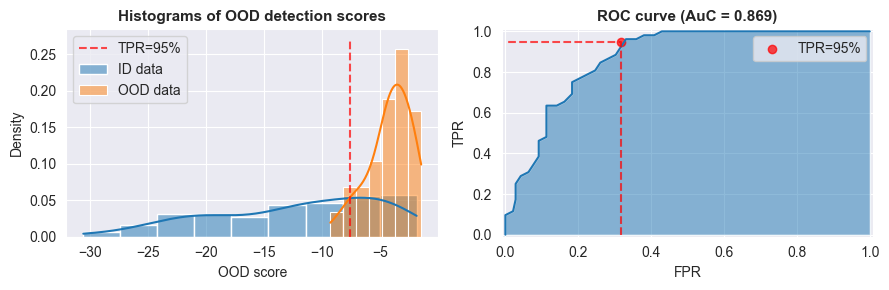

In [4]:
from oodeel.methods import Energy
from oodeel.eval.metrics import bench_metrics
from oodeel.eval.plots import plot_ood_scores, plot_roc_curve, plot_2D_features

energy = Energy()
energy.fit(model)
images = np.zeros((len(valid_df), img_size, img_size, 3))
for i, f in enumerate(valid_df.image_Addr):
    img_file = load_and_process(f, "../data/x_ray")
    images[i] = img_file[0]
scores_in, _ = energy.score(images)


images = np.zeros((len(bad_files), img_size, img_size, 3))
for i, f in enumerate(bad_files):
    img_file = load_and_process(f, "../data/x_ray")
    images[i] = img_file[0]
scores_out, _ = energy.score(images)    

metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
print(f"Threshold = {np.percentile(scores_out, q=5.0)}")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()